In [396]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
from astroNN.nn.layers import MCDropout
from scipy import spatial

import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [453]:

syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)


data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
dist = data[:,1]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)

print(np.shape(data[:,1]), np.shape(errors), np.shape(syscov))

-0.01084098704 0.02815552265 0.00039265133851975654
(31,) (31,) (31, 31)


In [398]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(dist.reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalererr.transform(errors.reshape(nsize,1))

In [399]:
import math

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = 10**orderMag(matrix[row, col])
    return magMatrix
            
            

In [400]:
def matrixGenerator(omatrix, nmatrix, freq_original=100, noise_factor=0.5):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
#         perm = np.random.permutation(nsize)
#         P = np.eye(nsize)[perm]
        print("Generating matrix {}".format(it), end='\r')
#         if it % freq_original ==0:

#         else:
#             m = P@omatrix@P.T
       
        mag = matrixMag(omatrix)
#         m = symmetrical(m) 
        m = omatrix + np.multiply(noise_factor*np.random.rand(nsize,nsize), mag)
#         m = symmetrical(m) 
        
#         D, P = sp.linalg.eigh(m)
#         D = np.diag(D)
        
        matrixset[it, :, :] = m
        
    return matrixset

### Generate a data set with covariance matrix from the original plus gaussian noise

In [331]:
numMatrix = 1000
# covset, D = matrixGenerator3(syscov, numMatrix)
covset = matrixGenerator(syscov, numMatrix, noise_factor=0.5)
covset_noise = matrixGenerator(syscov, numMatrix, noise_factor=10)

(1000, 31, 31)


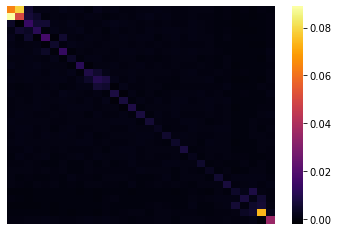

In [332]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(covset_noise_test[0,:,:], 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [341]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31 

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(500, activation='relu')(input_img)
# x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
x = layers.Dense(50, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='relu')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(50, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
x = layers.Dense(500, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        [(None, 961)]             0         
_________________________________________________________________
dense_264 (Dense)            (None, 500)               481000    
_________________________________________________________________
dense_265 (Dense)            (None, 100)               50100     
_________________________________________________________________
dense_266 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_267 (Dense)            (None, 31)                1581      
_________________________________________________________________
dropout_120 (Dropout)        (None, 31)                0         
_________________________________________________________________
dense_268 (Dense)            (None, 50)                16

In [342]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

# decoder_layer1 = autoencoder.layers[-7]
# decoder_layer2 = autoencoder.layers[-6]
decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(
                    decoder_layer4(decoder_layer3(
                        decoder_layer2(decoder_layer1(encoded_input))))))

In [343]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=100,
                batch_size=32,
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))
#                 callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100
25/25 [==============================] - 0s 9ms/step - loss: 1.5116e-06 - val_loss: 1.1543e-07
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 5.8175e-08 - val_loss: 1.8487e-08
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 1.8169e-08 - val_loss: 1.5360e-08
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 1.4647e-08 - val_loss: 1.4638e-08
Epoch 5/100
25/25 [==============================] - 0s 6ms/step - loss: 1.4527e-08 - val_loss: 1.4792e-08
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 1.4444e-08 - val_loss: 1.4934e-08
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 1.4242e-08 - val_loss: 1.4729e-08
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 1.4700e-08 - val_loss: 1.4764e-08
Epoch 9/100
25/25 [==============================] - 0s 6ms/step - loss: 1.4671e-08 - val_loss: 1.4784e-08
Epoch 10/100
25/25 [=================

Epoch 77/100
25/25 [==============================] - 0s 5ms/step - loss: 1.5418e-08 - val_loss: 1.5694e-08
Epoch 78/100
25/25 [==============================] - 0s 5ms/step - loss: 1.5570e-08 - val_loss: 1.5778e-08
Epoch 79/100
25/25 [==============================] - 0s 5ms/step - loss: 1.5387e-08 - val_loss: 1.5932e-08
Epoch 80/100
25/25 [==============================] - 0s 5ms/step - loss: 1.5492e-08 - val_loss: 1.6727e-08
Epoch 81/100
25/25 [==============================] - 0s 5ms/step - loss: 1.6165e-08 - val_loss: 1.5812e-08
Epoch 82/100
25/25 [==============================] - 0s 5ms/step - loss: 1.5642e-08 - val_loss: 1.5866e-08
Epoch 83/100
25/25 [==============================] - 0s 5ms/step - loss: 1.5623e-08 - val_loss: 1.5924e-08
Epoch 84/100
25/25 [==============================] - 0s 6ms/step - loss: 1.5729e-08 - val_loss: 1.5612e-08
Epoch 85/100
25/25 [==============================] - 0s 5ms/step - loss: 1.5753e-08 - val_loss: 1.5781e-08
Epoch 86/100
25/25 [========

(array([-1.e-07,  0.e+00,  1.e-07,  2.e-07,  3.e-07,  4.e-07,  5.e-07,
         6.e-07,  7.e-07,  8.e-07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

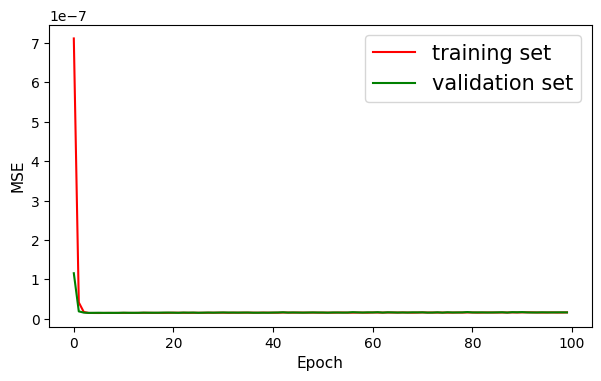

In [344]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [345]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.4637500100889154e-08 1.4390210800740988e-08


In [346]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(200, 31)


(200, 961)


<AxesSubplot:>

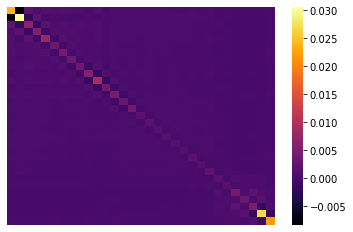

In [401]:
print(np.shape(decoded_imgs))
# m = decoded_imgs[0].reshape(31,31)@D@decoded_imgs[0].reshape(31,31).T
# m = scalercov.inverse_transform(m)

sns.heatmap(decoded_imgs[0].reshape(31,31), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


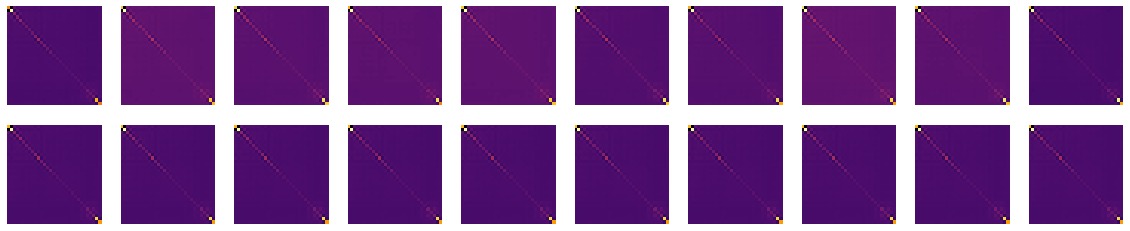

In [348]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
   
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

In [349]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

In [354]:
testmatrix = np.zeros((31,31))
err = np.random.rand() 
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            testmatrix[row, col] = syscov[row, col]
        else:
            testmatrix[row, col] = syscov[row, col] + err*orderMag(syscov[row, col])

clean_img = autoencoder.predict(testmatrix.reshape(-1, 31*31,))


<AxesSubplot:>

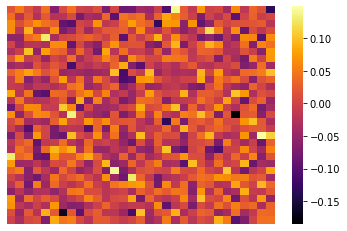

In [355]:
# m = clean_img[0].reshape(31,31)@D@clean_img[0].reshape(31,31).T
m = clean_img[0].reshape(31,31)
sns.heatmap(m, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)


In [510]:
np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")

In [357]:
autoencoder.save('../models/autoencoderJLA.h5')
decoder.save('../models/decoderJLA.h5')
encoder.save('../models/encoderJLA.h5')

# Loading ffnn model

In [549]:
# ranz = np.random.uniform(0, 1.3, (nsize,))
# ranz = np.linspace(0.01, 1.3, 31)
ranz = z_redshift + 0.001*np.random.rand()
ranz

array([0.01840386, 0.02016542, 0.02223728, 0.02467412, 0.02754021,
       0.03091119, 0.03487598, 0.03953919, 0.04502385, 0.05147467,
       0.05906183, 0.06798552, 0.07848116, 0.09082567, 0.10534473,
       0.12242141, 0.14250623, 0.16612912, 0.1939133 , 0.22659183,
       0.26502686, 0.31023243, 0.36340122, 0.425936  , 0.49948662,
       0.58599359, 0.68773925, 0.80740798, 0.94815703, 1.1136998 ,
       1.30840386])

In [557]:
# ffnn = tf.keras.models.load_model('../models/FFNN_JLA.h5')
# ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})


# index = np.argsort(ranz)
# ranz = ranz[index]
# # ranz= z

# pred_random = ffnn.predict(np.log(ranz))
# pred_dl = pred_random[:,0].reshape(-1,1)

# # pred_dl_sc = scalerdist.transform(pred_dl)
# pred_dl_sc = pred_dl.reshape(31,)[index]
# pred_err = np.exp(pred_random[:,1][index].reshape(-1,1))
# dlfake = scalerdist.inverse_transform(pred_dl.reshape(31,)[index])

# fake_data = np.stack((ranz[index], dlfake[index]), axis=1)

# np.savetxt("fake_binned_JLA2TEST3new.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

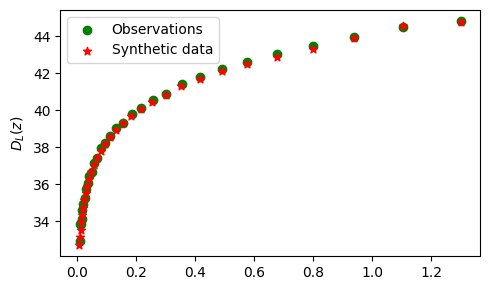

In [559]:
data = np.loadtxt("fake_binned_JLA2TEST3new.dat")
ranz = data[:,0]
dlfake = data[:,1]
plt.figure(figsize=(5, 3), dpi=100)

plt.scatter(z, dl, c='g', label='Observations')
plt.scatter(ranz, dlfake, c='r', label='Synthetic data', marker='*')

plt.ylabel("$D_L(z)$")
# plt.xlim(-0.1, np.max(z)+0.2)
plt.tight_layout()
plt.legend()
# plt.savefig('rec_jla_ffnn.png')

In [552]:
diagmat_err = np.zeros((31,31))
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            diagmat_err[row, col] = pred_err[row]

diagmat_err = scalercov.transform(diagmat_err)
diagmat_err = np.diag(diagmat_err)

diags = [np.diag(matrix) for matrix in covset_noise]
tree = spatial.KDTree(diags)
distance, index = tree.query(diagmat_err)
distance, index 

(29.523144028776333, 327)

In [553]:
diagmat_err = np.zeros((31,31))
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            diagmat_err[row, col] = pred_err[row]
        else:
            diagmat_err[row, col] = covset_noise[index, row, col]

Text(0.5, 1.0, 'nearest covset_test matrix DECODED')

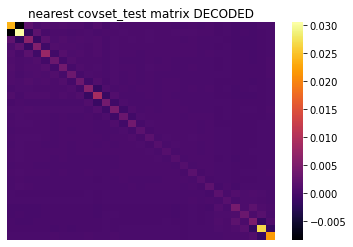

In [554]:
# cod = encoder.predict(covset[index,:,:].reshape(-1,31*31))
cod = encoder.predict(diagmat_err.reshape(-1,31*31))
covpred = decoder.predict(cod)

sns.heatmap(covpred.reshape(31,31), 
# sns.heatmap(covset_noise[index].reshape(31,31), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('nearest covset_test matrix DECODED')

In [556]:
np.savetxt("fake_binned_JLA_COVdecodedTEST3vae_new.dat", covpred.reshape(31,31), delimiter= " ", header="#fake COV")
# np.savetxt("fake_binned_JLA_COVdecodedTEST3ae.dat", covset[index,:,:].reshape(31,31), delimiter= " ", header="#fake COV")